# Network Analysis

This notebook provide analysis metrics on 3 complex networks: 

- [Amazon Co-purchase](http://snap.stanford.edu/data/com-Amazon.html)
- [Wikipedia Admin Election](http://snap.stanford.edu/data/wiki-Elec.html)
- [World Cities and Global Firms](https://www.lboro.ac.uk/gawc/datasets/da6.html)
- [Les Miserables Coappearance](http://www-personal.umich.edu/~mejn/netdata/)

The following metrics are obtained: 

- Degree
- Distance 
- Closeness

## Imports

In [1]:
import networkx as nx
from powerlaw import ccdf
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np

### Initializing Variables

In [161]:
dict_metrics = {}
dict_plots = {}
df_output = pd.DataFrame(columns=["dataset_tag", "metric", "max", "min", "mean", "median", "std"])

## Processing Datafiles

For each dataset, a source file is processed in order to create an adjacency-list output file.

### Amazon Co-purchase

In [147]:
dataset_tag, dataset_file = "amazon_copurchase", "./com-amazon.ungraph.txt"
dict_metrics[dataset_tag] = dict()
dict_plots[dataset_tag] = dict()
df = pd.read_csv(dataset_file, header=None, skiprows=4, sep='\t')
df.columns = ["from", "to"]
df.to_csv("./" + dataset_tag + "_edgelist.txt", sep='\t', index=False, header=None)
df.tail()

,from,to
925867,548343,548378
925868,548354,548356
925869,548368,548454
925870,548391,548411
925871,548411,548458


### Movie Lens 1M

In [149]:
dataset_tag, dataset_file = "ml1m", "./ratings.dat"
dict_metrics[dataset_tag] = dict()
dict_plots[dataset_tag] = dict()
df = pd.read_csv(dataset_file, header=None, sep=r'::', engine="python")
df.columns = ["from", "to", "rating", "timestamp"]
df['from'] = df['from'].apply(lambda x: 'user_' + str(x))
df['to'] = df['to'].apply(lambda x: 'item_' + str(x))
df.drop(["timestamp"], axis=1, inplace=True)
df.to_csv("./" + dataset_tag + "_edgelist.txt", sep='\t', index=False, header=None)
df.head()

,from,to,rating
0,user_1,item_1193,5
1,user_1,item_661,3
2,user_1,item_914,3
3,user_1,item_3408,4
4,user_1,item_2355,5


### World Cities and Global Companies

In [106]:
dataset_tag, dataset_file = "wcgc", "./world_cities.csv"
dict_metrics[dataset_tag] = dict()
dict_plots[dataset_tag] = dict()
df = pd.read_csv(dataset_file, header=1, sep=',', engine="python")
# df.set_index(["CITIES"], inplace=True)
df.drop(["Unnamed: 47"], axis=1, inplace=True)
df = df.melt(id_vars=["CITIES"])
df.columns = ["from", "to", "weight"]
df.to_csv("./" + dataset_tag + "_edgelist.txt", sep='\t', index=False, header=None)
df.head()

,from,to,weight
0,Amsterdam,KP,3
1,Atlanta,KP,3
2,Bangkok,KP,1
3,Barcelona,KP,1
4,Beijing,KP,1


### Les Miserables Coappearance

In [162]:
dataset_tag, dataset_file = "lesmis", "./lesmis.gml"
dict_metrics[dataset_tag] = dict()
dict_plots[dataset_tag] = dict()

## Creating Network

In [163]:
if dataset_tag == "ml1m":
    G = nx.DiGraph()
    for user_id in df["from"].unique():
        G.add_node(user_id, node_type="user")
    for item_id in df["to"].unique():
        G.add_node(item_id, node_type="item")
    G.add_weighted_edges_from(df[["from", "to", "rating"]].values)
elif dataset_tag == "wcgc":
    G = nx.Graph()
    for city in df["from"].unique():
        G.add_node(city, node_type="city")
    for company in df["to"].unique():
        G.add_node(company, node_type="company")
    G.add_weighted_edges_from(df[["from", "to", "weight"]].values)    
elif dataset_tag == "lesmis":
    G = nx.read_gml(dataset_file)
    df = pd.DataFrame([[char_1, char_2, coapp['value']] for (char_1, char_2, coapp) in G.edges.data()], columns=["from", "to", "weight"])
else: 
    G = nx.read_edgelist("./" + dataset_tag + "_edgelist.txt", delimiter='\t', nodetype=str, data=(('weight',float),))
print (list(G.edges)[:3])
print ("Number of edges: ", G.number_of_edges())
print ("Number of nodes: ", G.number_of_nodes())
if dataset_tag == "wcgc":
    for node_type in ["city", "company"]:
        n_type_nodes = G.subgraph([n for n,attrdict in G.node.items() if attrdict['node_type'] == node_type] ).number_of_nodes()
        print ("Number of " + node_type + " nodes: ", n_type_nodes)
    
if dataset_tag == "ml1m":
    for node_type in ["user", "item"]:
        n_type_nodes = G.subgraph([n for n,attrdict in G.node.items() if attrdict['node_type'] == node_type] ).number_of_nodes()
        print ("Number of " + node_type + " nodes: ", n_type_nodes)

print ("Transitivity: ", nx.transitivity(G))
if not G.is_directed():
    print ("Is connected: ", nx.is_connected(G))
    print ("Number of connected components: ", nx.number_connected_components(G))
else:
    print ("Is strongly connected: ", nx.is_strongly_connected(G))
    print ("Number of strongly connected components: ", nx.number_strongly_connected_components(G))

[('Myriel', 'Napoleon'), ('Myriel', 'MlleBaptistine'), ('Myriel', 'MmeMagloire')]
Number of edges:  254
Number of nodes:  77
Transitivity:  0.49893162393162394
Is connected:  True
Number of connected components:  1


## Getting Stats


### Degrees

In [164]:
df_stats = pd.DataFrame(nx.degree(G))
df_stats.columns = ['node', 'degree']
df_stats['degree_centrality'] = nx.degree_centrality(G).values()
dict_metrics[dataset_tag]["degree"] = np.array(df_stats["degree"])
df_stats.tail()

,node,degree,degree_centrality
72,Toussaint,3,0.039474
73,Child1,2,0.026316
74,Child2,2,0.026316
75,Brujon,7,0.092105
76,MmeHucheloup,7,0.092105


In [165]:
df_output.loc[df_output.shape[0]] = [dataset_tag, 
     "degree", df_stats["degree"].max(), df_stats["degree"].min(), 
     '{:.02f}'.format(df_stats["degree"].mean()), 
     '{:.02f}'.format(df_stats["degree"].median()),
     '{:.02f}'.format(df_stats["degree"].std())]
df_output

,dataset_tag,metric,max,min,mean,median,std
0,lesmis,degree,36,1,6.60,6.00,6.04


In [153]:
if G.is_directed():
    df_output.loc[df_output.shape[0]] = [dataset_tag, "out-degree", 
         df_stats[df_stats.node.str.contains("user")]["degree"].max(), 
         df_stats[df_stats.node.str.contains("user")]["degree"].min(), 
         '{:.02f}'.format(df_stats[df_stats.node.str.contains("user")]["degree"].mean()), 
         '{:.02f}'.format(df_stats[df_stats.node.str.contains("user")]["degree"].median()),
         '{:.02f}'.format(df_stats[df_stats.node.str.contains("user")]["degree"].std())]

    df_output.loc[df_output.shape[0]] = [dataset_tag, "in-degree", 
         df_stats[df_stats.node.str.contains("item")]["degree"].max(), 
         df_stats[df_stats.node.str.contains("item")]["degree"].min(), 
         '{:.02f}'.format(df_stats[df_stats.node.str.contains("item")]["degree"].mean()), 
         '{:.02f}'.format(df_stats[df_stats.node.str.contains("item")]["degree"].median()),
         '{:.02f}'.format(df_stats[df_stats.node.str.contains("item")]["degree"].std())]
df_output   

,dataset_tag,metric,max,min,mean,median,std
0,ml1m,degree,3428,1,205.26,102.00,285.77
1,ml1m,out-degree,2314,20,165.60,96.00,192.75
2,ml1m,in-degree,3428,1,269.89,123.50,384.05


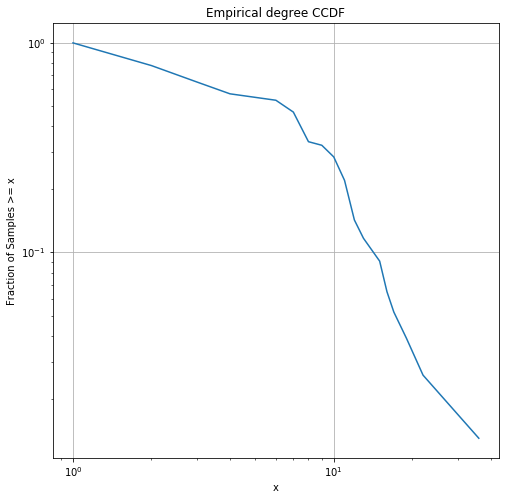

In [166]:
def plot_ccdf(samples, name=''):
    x, y = ccdf(samples)
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
    ax.set_title("Empirical " + name + " CCDF")
    ax.plot(x, y)
    ax.set_xscale("log"), ax.set_yscale("log")
    ax.set_xlabel("x"), ax.set_ylabel("Fraction of Samples >= x")
    ax.grid(True)
    return fig, ax 

fig, ax = plot_ccdf(df_stats["degree"], "degree")
dict_plots[dataset_tag]["degree"] = dict()
dict_plots[dataset_tag]["degree"]["fig"], dict_plots[dataset_tag]["degree"]["ax"] = fig, ax
fig.savefig("./images/{}_empirical_degrees_ccdf.jpeg".format(dataset_tag), bbox_inches="tight")

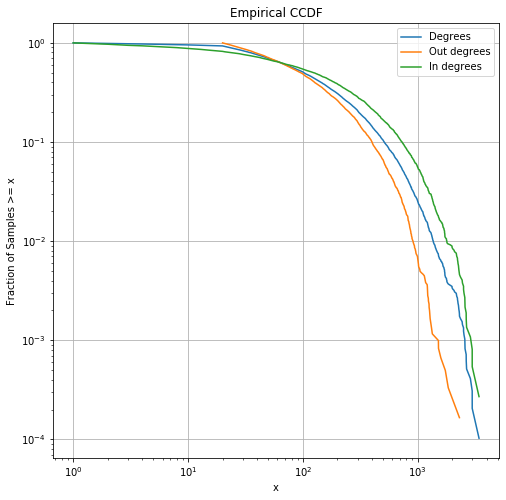

In [160]:
if dataset_tag == "ml1m":    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
    
    x, y = ccdf(df_stats["degree"])       
    ax.plot(x, y, label="Degrees")
    
    x, y = ccdf(df_stats[df_stats.node.str.contains("user")]["degree"])       
    ax.plot(x, y, label="Out degrees")
    
    x, y = ccdf(df_stats[df_stats.node.str.contains("item")]["degree"])       
    ax.plot(x, y, label="In degrees")
    
    ax.set_title("Empirical CCDF")
    ax.set_xscale("log"), ax.set_yscale("log")
    ax.set_xlabel("x"), ax.set_ylabel("Fraction of Samples >= x")
    ax.legend()
    ax.grid(True)

    dict_plots[dataset_tag]["in-out-degree"] = dict()
    dict_plots[dataset_tag]["in-out-degree"]["fig"], dict_plots[dataset_tag]["in-out-degree"]["ax"] = fig, ax
    fig.savefig("./images/{}_empirical_in_out_degrees_ccdf.jpeg".format(dataset_tag), bbox_inches="tight")
    

## Sample-based Metrics

In [167]:
%%time
n_trial_nodes = 500
arr_dist = arr_close = arr_clust = np.array([])
if n_trial_nodes >= G.number_of_nodes():
    metric_nodes = df_stats["node"].unique() 
else: 
    metric_nodes = np.random.choice(df_stats["node"].unique(), size=n_trial_nodes)

for node in metric_nodes:
    node_dist = np.array(list(nx.shortest_path_length(G, node).values())[1:])
    node_close = nx.closeness_centrality(G, node)
    arr_dist = np.append(arr_dist, node_dist)
    arr_close = np.append(arr_close, node_close)
    arr_clust = np.append(arr_clust, nx.clustering(G, node))
    
dict_metrics[dataset_tag]["distance"] = arr_dist
dict_metrics[dataset_tag]["closeness"] = arr_close
dict_metrics[dataset_tag]["clustering"] = arr_clust

Wall time: 98.1 ms


### Distance

In [85]:
df_output.loc[df_output.shape[0]] = [dataset_tag, "distance", 
     arr_dist.max(), arr_dist.min(), 
     '{:.02f}'.format(arr_dist.mean()), 
     '{:.02f}'.format(np.median(arr_dist)),
     '{:.02f}'.format(arr_dist.std())]
df_output

,dataset_tag,metric,max,min,mean,median,std
0,ml1m,degree,3428,1,205.26,102.00,285.77
1,ml1m,out-degree,2314,20,165.60,96.00,192.75
2,ml1m,in-degree,3428,1,269.89,123.50,384.05
3,ml1m,distance,1,1,1.00,1.00,0.00


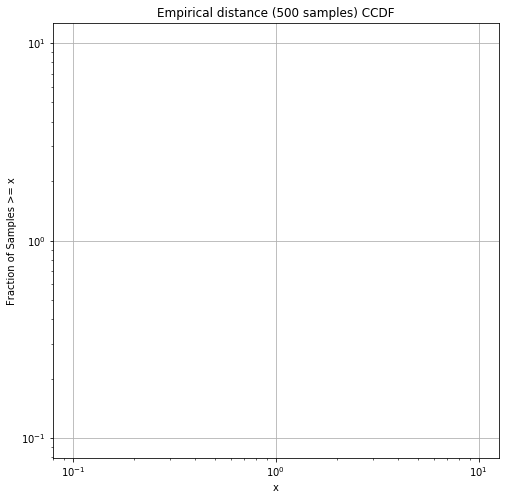

In [86]:
fig, ax = plot_ccdf(arr_dist, name="distance ({} samples)".format(n_trial_nodes))
dict_plots[dataset_tag]["distance"] = dict()
dict_plots[dataset_tag]["distance"]["fig"], dict_plots[dataset_tag]["distance"]["ax"] = fig, ax
fig.savefig("./images/{}_empirical_distances_ccdf.jpeg".format(dataset_tag), bbox_inches="tight")

### Closeness

In [87]:
df_output.loc[df_output.shape[0]] = [dataset_tag, "closeness", 
     arr_close.max(), arr_close.min(), 
     '{:.02f}'.format(arr_close.mean()), 
     '{:.02f}'.format(np.median(arr_close)),
     '{:.02f}'.format(arr_close.std())]
df_output

,dataset_tag,metric,max,min,mean,median,std
0,ml1m,degree,3428,1,205.26,102.00,285.77
1,ml1m,out-degree,2314,20,165.60,96.00,192.75
2,ml1m,in-degree,3428,1,269.89,123.50,384.05
3,ml1m,distance,1,1,1.00,1.00,0.00
4,ml1m,closeness,0.35177,0,0.01,0.00,0.04


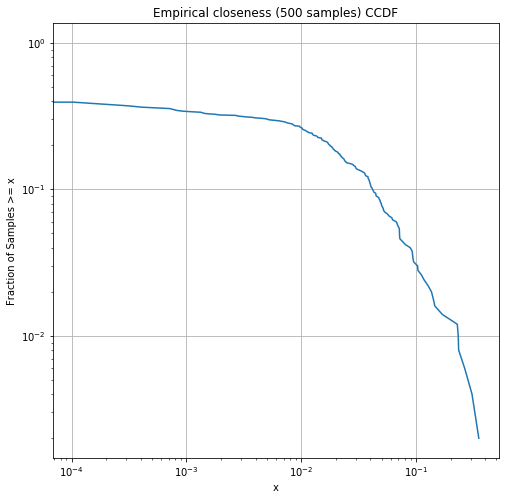

In [88]:
fig, ax = plot_ccdf(arr_close, name="closeness ({} samples)".format(n_trial_nodes))
dict_plots[dataset_tag]["closeness"] = dict()
dict_plots[dataset_tag]["closeness"]["fig"], dict_plots[dataset_tag]["closeness"]["ax"] = fig, ax
fig.savefig("./images/{}_empirical_closeness_ccdf.jpeg".format(dataset_tag), bbox_inches="tight")

In [89]:
df_output.to_csv("./stats_files/{}_stats_{}_samples.csv".format(dataset_tag, n_trial_nodes), sep=",", index=None)

In [134]:
df_stats.describe()

,degree,degree_centrality
count,77.000000,77.000000
mean,6.597403,0.086808
std,6.039911,0.079473
min,1.000000,0.013158
25%,2.000000,0.026316
50%,6.000000,0.078947
75%,10.000000,0.131579
max,36.000000,0.473684


## Plotting All Datasets

### WCGC Weight Analysis

In [69]:
df.groupby("from").sum().sort_values(by=["weight"], ascending=False).head(3)

,weight
from,
New York,105
London,97
Paris,71


In [116]:
df.groupby("from").mean().sort_values(by=["weight"], ascending=False).tail(3)

,weight
from,
Atlanta,0.391304
Osaka,0.347826
Minneapolis,0.282609


In [70]:
df.groupby("to").sum().sort_values(by=["weight"], ascending=False).head(3)

,weight
to,
CL,120
KP,119
EY,115


In [117]:
df.groupby("to").mean().sort_values(by=["weight"], ascending=False).tail(3)

,weight
to,
SQ,0.218182
BC,0.200000
MC,0.054545


Diameter

In [104]:
print ("Diameter: ", nx.diameter(G))

Diameter:  5


## LesMis Analysis

Doubles with the most co-appearances

In [153]:
df[df.weight == df.max()["weight"]]

,from,to,weight
21,Valjean,Cosette,31


Characters who appeared the most with any other character

In [148]:
df.groupby("from").sum().sort_values(by=["weight"], ascending=False).head(3)

,weight
from,
Valjean,146
Enjolras,66
Gavroche,51


In [150]:
df.groupby("to").sum().sort_values(by=["weight"], ascending=False).head(3)

,weight
to,
Marius,72
Courfeyrac,58
Bossuet,55


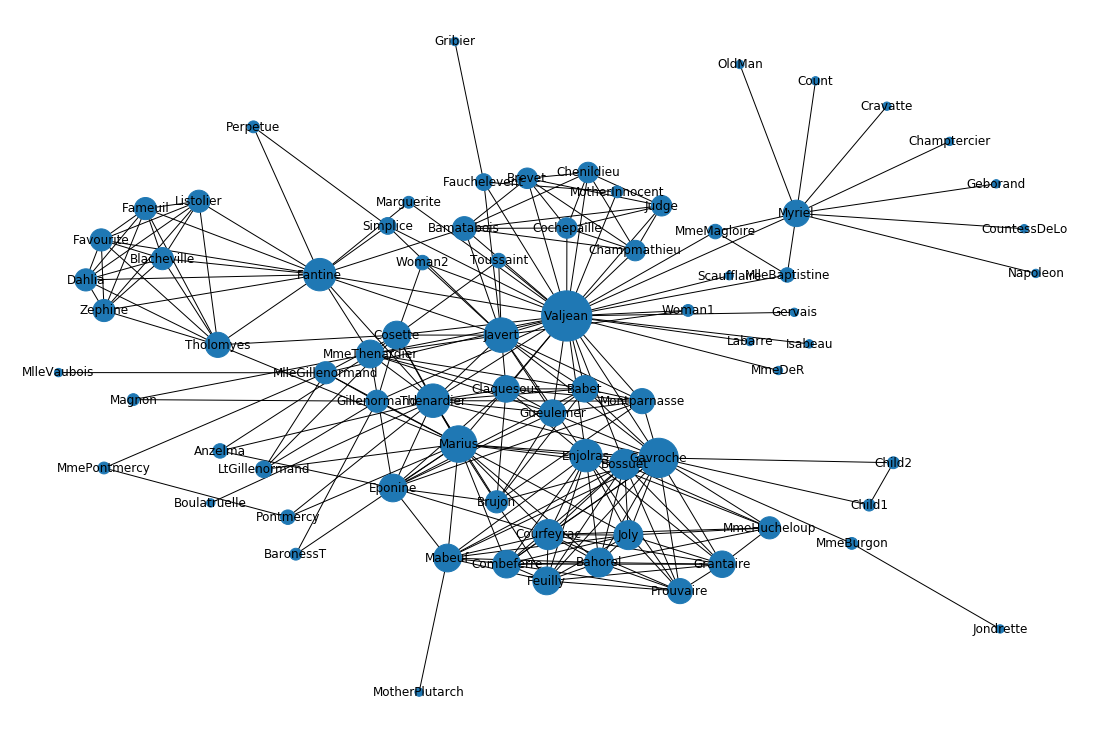

In [130]:
def draw_node_size_by_deg (g, scale=None, with_labels=True, hight = 15, widith = 10): 
    plt.rcParams["figure.figsize"] = (hight,widith)
    degree = nx.degree(g) # degree centrality
    node_list = [n for (n,m) in degree]
    degree_list = [int(m) for (n, m) in degree]  
    if scale==None:
        nx.draw_kamada_kawai(g, with_labels=with_labels,nodelist=node_list,node_size=[n*70 for n in degree_list])
    else:        
        nx.draw_kamada_kawai(g, with_labels=with_labels,nodelist=node_list,node_size=[n*scale for n in degree_list])
    
    plt.savefig("./images/karate_graph.png")
    
    plt.show()
    plt.close()
    
draw_node_size_by_deg(G)

_______________

In [179]:
G=nx.DiGraph()

G.add_edge('u1','i1',weight=0.6)
G.add_edge('u1','i2',weight=0.2)
G.add_edge('u2','i1',weight=0.1)

KeyError: 'a'

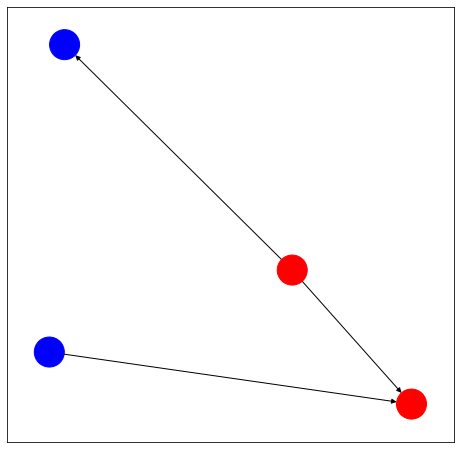

In [180]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
nx.draw(G,pos=nx.spring_layout(G), 
        label="uhu", 
        node_size=900, 
        node_color=['r', 'r', 'b', 'b'],
        labels={'u1': 'u1', 'u2': 'u2', 'i1': 'i1', 'd': 4},
        ax=ax)
plt.show()